In [1]:
#%pip install xesmf

In [2]:
import os
#must set these before loading numpy:
#os.environ["OMP_NUM_THREADS"] = '4' # export OMP_NUM_THREADS=4
#os.environ["OPENBLAS_NUM_THREADS"] = '4' # export OPENBLAS_NUM_THREADS=4 
#os.environ["MKL_NUM_THREADS"] = '4' # export MKL_NUM_THREADS=6
#os.environ["VECLIB_MAXIMUM_THREADS"] = '4' # export VECLIB_MAXIMUM_THREADS=4
#os.environ["NUMEXPR_NUM_THREADS"] = '4' # export NUMEXPR_NUM_THREADS=6


import matplotlib.pyplot as plt
import matplotlib, sys
#matplotlib.use('Agg')

import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
#import netCDF4 as nc4
import time
import dask.array as da
import sys
import s3fs
import datetime


import cartopy.crs as ccrs
import pyproj
import time
import gc
from glob import glob

import xesmf as xe

In [3]:
def read_IS2SITMOGR4(data_type='zarr-s3', version='V3', local_data_path="/data/IS2SITMOGR4/", 
    bucket_name="icesat-2-sea-ice-us-west-2", persist=True, download=False): 
    """ Read in IS2SITMOGR4 monthly gridded thickness dataset from local netcdf files, download the netcdf files from S3 storage, or read in the aggregated zarr dataset from S3. Currently supports either Version 2 (V2) or Version 3 (V3) data. 
    
    Note than in Version 3 there was a change in the xgrid/ygrid coordinates to x/y.
    
    Args: 
        data_type (str, required): (default to "zarr-s3", but also "netcdf-s3" or "netcdf-local" which is a local version of the netcdf files)
        version (str, required): IS2SITMOGR4 version (default "V2")
        local_data_path (str, required): local data directory
        bucket_name (str, required): S3 bucket name
        persist (boleen, required): if zarr option decide if you want to persist (load) data into memory
        download (boleen, required): download from s3 bucket to local storage

    Returns: 
        is2_ds (xr.Dataset): aggregated IS2SITMOGR4 xarray dataset, dask chunked/virtually allocated in the case of the zarr option (or allocated to memory if persisted). 
        
    Version History: 
        (November 2023 for V3 data release):  
            - Moved the download code to it's own section at the start of the function
            - Changed local paths
            - Baked in the date_str label as that is just a function of the dataset version anyway
            - Adapted the netcdf reader to use open_mfdataset, required a preprocessing data dimension step. Much more elegant!
    
    """
    
    if download==True:
        print("download from S3 bucket: ", bucket_name)

        # Download netCDF data files
        s3_path = 's3://'+bucket_name+'/IS2SITMOGR4_'+version+'/netcdf/'
        fs = s3fs.S3FileSystem(anon=True)

        #files references the entire bucket.
        files = fs.ls(s3_path)
        for file in files:
            print('Downloading file from bucket to local storage...', file)
            fs.download(file, local_data_path+version+'/')
        
    if data_type=='zarr-s3':
        if version=='V2':
            date_str='201811-202204'
        else:
            date_str='201811-202304'
        print('load zarr from S3 bucket: ', bucket_name)
        s3_path = 's3://'+bucket_name+'/IS2SITMOGR4_'+version+'/zarr/IS2SITMOGR4_'+version+'_'+date_str+'.zarr/all/'
        print('zarr_path:', s3_path)
        s3 = s3fs.S3FileSystem(anon=True)
        store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
        is2_ds = xr.open_zarr(store=store)
        
        # Had a problem with these being loaded as dask arrays which cartopy doesnt like
        is2_ds = is2_ds.assign_coords(longitude=(["y","x"], is2_ds.longitude.values))
        is2_ds = is2_ds.assign_coords(latitude=(["y","x"], is2_ds.latitude.values))

        if persist==True:
            is2_ds = is2_ds.persist()

    elif data_type=='netcdf':
        
        filenames = glob.glob(local_data_path+version+'/*.nc')
        if len(filenames) == 0: 
            raise ValueError("No files, exit")
            return None
        
        dates = [pd.to_datetime(file.split("IS2SITMOGR4_01_")[1].split("_")[0], format = "%Y%m")  for file in filenames]
        # Add a dummy time then add the dates I want, seemed the easiest solution
        if version=='V2':
            is2_ds = xr.open_mfdataset(filenames, preprocess = add_time_dim_v2, engine='netcdf4')
        else:
            is2_ds = xr.open_mfdataset(filenames, preprocess = add_time_dim_v3, engine='netcdf4')
                
        is2_ds["time"] = dates

        # Sort by time as glob file list wasn't!
        is2_ds = is2_ds.sortby("time")
        if version=='V2':
            is2_ds = is2_ds.set_coords(["latitude","longitude","xgrid","ygrid"]) 
        else:
            is2_ds = is2_ds.set_coords(["latitude","longitude","x","y"])
        
        is2_ds = is2_ds.assign_coords(longitude=(["y","x"], is2_ds.longitude.values))
        is2_ds = is2_ds.assign_coords(latitude=(["y","x"], is2_ds.latitude.values))
        
        is2_ds = is2_ds.assign_attrs(description="Aggregated IS2SITMOGR4 "+version+" dataset.")

    return is2_ds

In [4]:
is2_ds = read_IS2SITMOGR4(data_type='zarr-s3', persist=True)

is2_ds = is2_ds[['freeboard', 'freeboard_int', 'snow_depth', 'snow_depth_int', 'ice_thickness','ice_thickness_int', 'ice_thickness_unc']]

is2_ds=is2_ds.rename({'ice_thickness': 'sea_ice_thickness'})
is2_ds=is2_ds.rename({'ice_thickness_int': 'sea_ice_thickness_int'})
is2_ds=is2_ds.rename({'ice_thickness_unc': 'sea_ice_thickness_unc'})
is2_ds=is2_ds.rename({'freeboard': 'total_freeboard'})
is2_ds=is2_ds.rename({'freeboard_int': 'total_freeboard_int'})
is2_ds=is2_ds.rename({'snow_depth': 'snow_thickness'})
is2_ds=is2_ds.rename({'snow_depth_int': 'snow_thickness_int'})


load zarr from S3 bucket:  icesat-2-sea-ice-us-west-2
zarr_path: s3://icesat-2-sea-ice-us-west-2/IS2SITMOGR4_V3/zarr/IS2SITMOGR4_V3_201811-202304.zarr/all/


/tmp/ipykernel_179/1720120290.py:50: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  is2_ds = xr.open_zarr(store=store)


In [5]:
is2_ds

<xarray.Dataset> Size: 146MB
Dimensions:                (time: 38, y: 448, x: 304)
Coordinates:
    latitude               (y, x) float32 545kB 31.1 31.2 31.3 ... 34.58 34.47
    longitude              (y, x) float32 545kB 168.3 168.1 ... -10.18 -9.999
  * time                   (time) datetime64[ns] 304B 2018-11-01 ... 2023-04-01
  * x                      (x) float32 1kB -3.838e+06 -3.812e+06 ... 3.738e+06
  * y                      (y) float32 2kB 5.838e+06 5.812e+06 ... -5.338e+06
Data variables:
    total_freeboard        (time, y, x) float32 21MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    total_freeboard_int    (time, y, x) float32 21MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_thickness         (time, y, x) float32 21MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_thickness_int     (time, y, x) float32 21MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    sea_ice_thickness      (time, y, x) float32 21MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    sea_ice_thickness_int  (time, y, x) float32 21MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    sea_ice_thickness_unc  (time, y, x) float32 21MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
Attributes:
    contact:      Alek Petty (akpetty@umd.edu)
    description:  November 2018 to April 2023 (zarr xarray dataset) IS2SITMOG...
    history:      Created 04/12/23
    reference:    Official NSIDC data doi: 10.5067/CV6JEXEE31HF. Derived data...

In [6]:
ease_grid = xr.open_dataset('~/Data/Extra/NSIDC0772_LatLon_EASE2_N25km_356_v1.0.nc')
ease_grid

<xarray.Dataset> Size: 2MB
Dimensions:    (x: 356, y: 356)
Coordinates:
  * x          (x) float64 3kB -4.438e+06 -4.412e+06 ... 4.412e+06 4.438e+06
  * y          (y) float64 3kB 4.438e+06 4.412e+06 ... -4.412e+06 -4.438e+06
Data variables:
    crs        int32 4B ...
    latitude   (y, x) float64 1MB ...
    longitude  (y, x) float64 1MB ...
Attributes: (12/40)
    CDI:                       Climate Data Interface version 2.0.5 (https://...
    institution:               \tNASA National Snow and Ice Data Center Distr...
    Conventions:               CF-1.6, ACDD-1.3
    title:                     EASE2 Grid Ancillary Grid Information
    summary:                   This data set provides the latitude and longit...
    id:                        10.5067/GE8ET0MZ5ZVF
    ...                        ...
    geospatial_lon_max:        180.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           1.0
    history:                   Thu Apr 25 17:19:48 2024: cdo selindexbox,183,...
    CDO:                       Climate Data Operators version 2.0.5 (https://...

In [7]:
# Initialize the regridder
# https://xesmf.readthedocs.io/en/stable/notebooks/Compare_algorithms.html
regridder = xe.Regridder(is2_ds.isel(time=0), ease_grid, 'nearest_s2d')

In [8]:
is2_ds_regridded = regridder(is2_ds)

In [9]:
is2_ds_regridded=is2_ds_regridded.rename({'x': 'xc'})
is2_ds_regridded=is2_ds_regridded.rename({'y': 'yc'})
is2_ds_regridded

<xarray.Dataset> Size: 135MB
Dimensions:                (time: 38, yc: 356, xc: 356)
Coordinates:
  * time                   (time) datetime64[ns] 304B 2018-11-01 ... 2023-04-01
  * xc                     (xc) float64 3kB -4.438e+06 -4.412e+06 ... 4.438e+06
  * yc                     (yc) float64 3kB 4.438e+06 4.412e+06 ... -4.438e+06
    crs                    int32 4B ...
Data variables:
    total_freeboard        (time, yc, xc) float32 19MB dask.array<chunksize=(1, 356, 356), meta=np.ndarray>
    total_freeboard_int    (time, yc, xc) float32 19MB dask.array<chunksize=(1, 356, 356), meta=np.ndarray>
    snow_thickness         (time, yc, xc) float32 19MB dask.array<chunksize=(1, 356, 356), meta=np.ndarray>
    snow_thickness_int     (time, yc, xc) float32 19MB dask.array<chunksize=(1, 356, 356), meta=np.ndarray>
    sea_ice_thickness      (time, yc, xc) float32 19MB dask.array<chunksize=(1, 356, 356), meta=np.ndarray>
    sea_ice_thickness_int  (time, yc, xc) float32 19MB dask.array<chunksize=(1, 356, 356), meta=np.ndarray>
    sea_ice_thickness_unc  (time, yc, xc) float32 19MB dask.array<chunksize=(1, 356, 356), meta=np.ndarray>
Attributes:
    regrid_method:  nearest_s2d

In [10]:
#plt.figure()
#is2_ds.freeboard.mean(axis=[1, 2]).plot(label='IS2SITMOGR4')
#is2_ds_regridded.freeboard.mean(axis=[1, 2]).plot(label='regridded', add_legend=True)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [11]:
#method_list = [
#    "bilinear",
#    "nearest_s2d",
#    "nearest_d2s",
#    "patch",
#]
#fig, axes = plt.subplots(2, 2, figsize=[8, 8])
#
#for i, method in enumerate(method_list):
#    print(method)
#    ax = axes.flatten()[i]
#    regridder = xe.Regridder(is2_ds.isel(time=0), ease_grid, method)
#    is2_ds_regridded = regridder(is2_ds)
#    is2_ds.freeboard_int.mean(axis=[1, 2]).plot(ax=ax, label='IS2SITMOGR4')
#    is2_ds_regridded.freeboard_int.mean(axis=[1, 2]).plot(ax=ax, label='regridded', add_legend=True)
#    ax.set_title(method, fontsize=15)

#plt.tight_layout()

2018-11
2018-12
2019-01
2019-02
2019-03
2019-04
2019-09
2019-10
2019-11
2019-12
2020-01
2020-02
2020-03
2020-04
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-09
2021-10
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03
2023-04


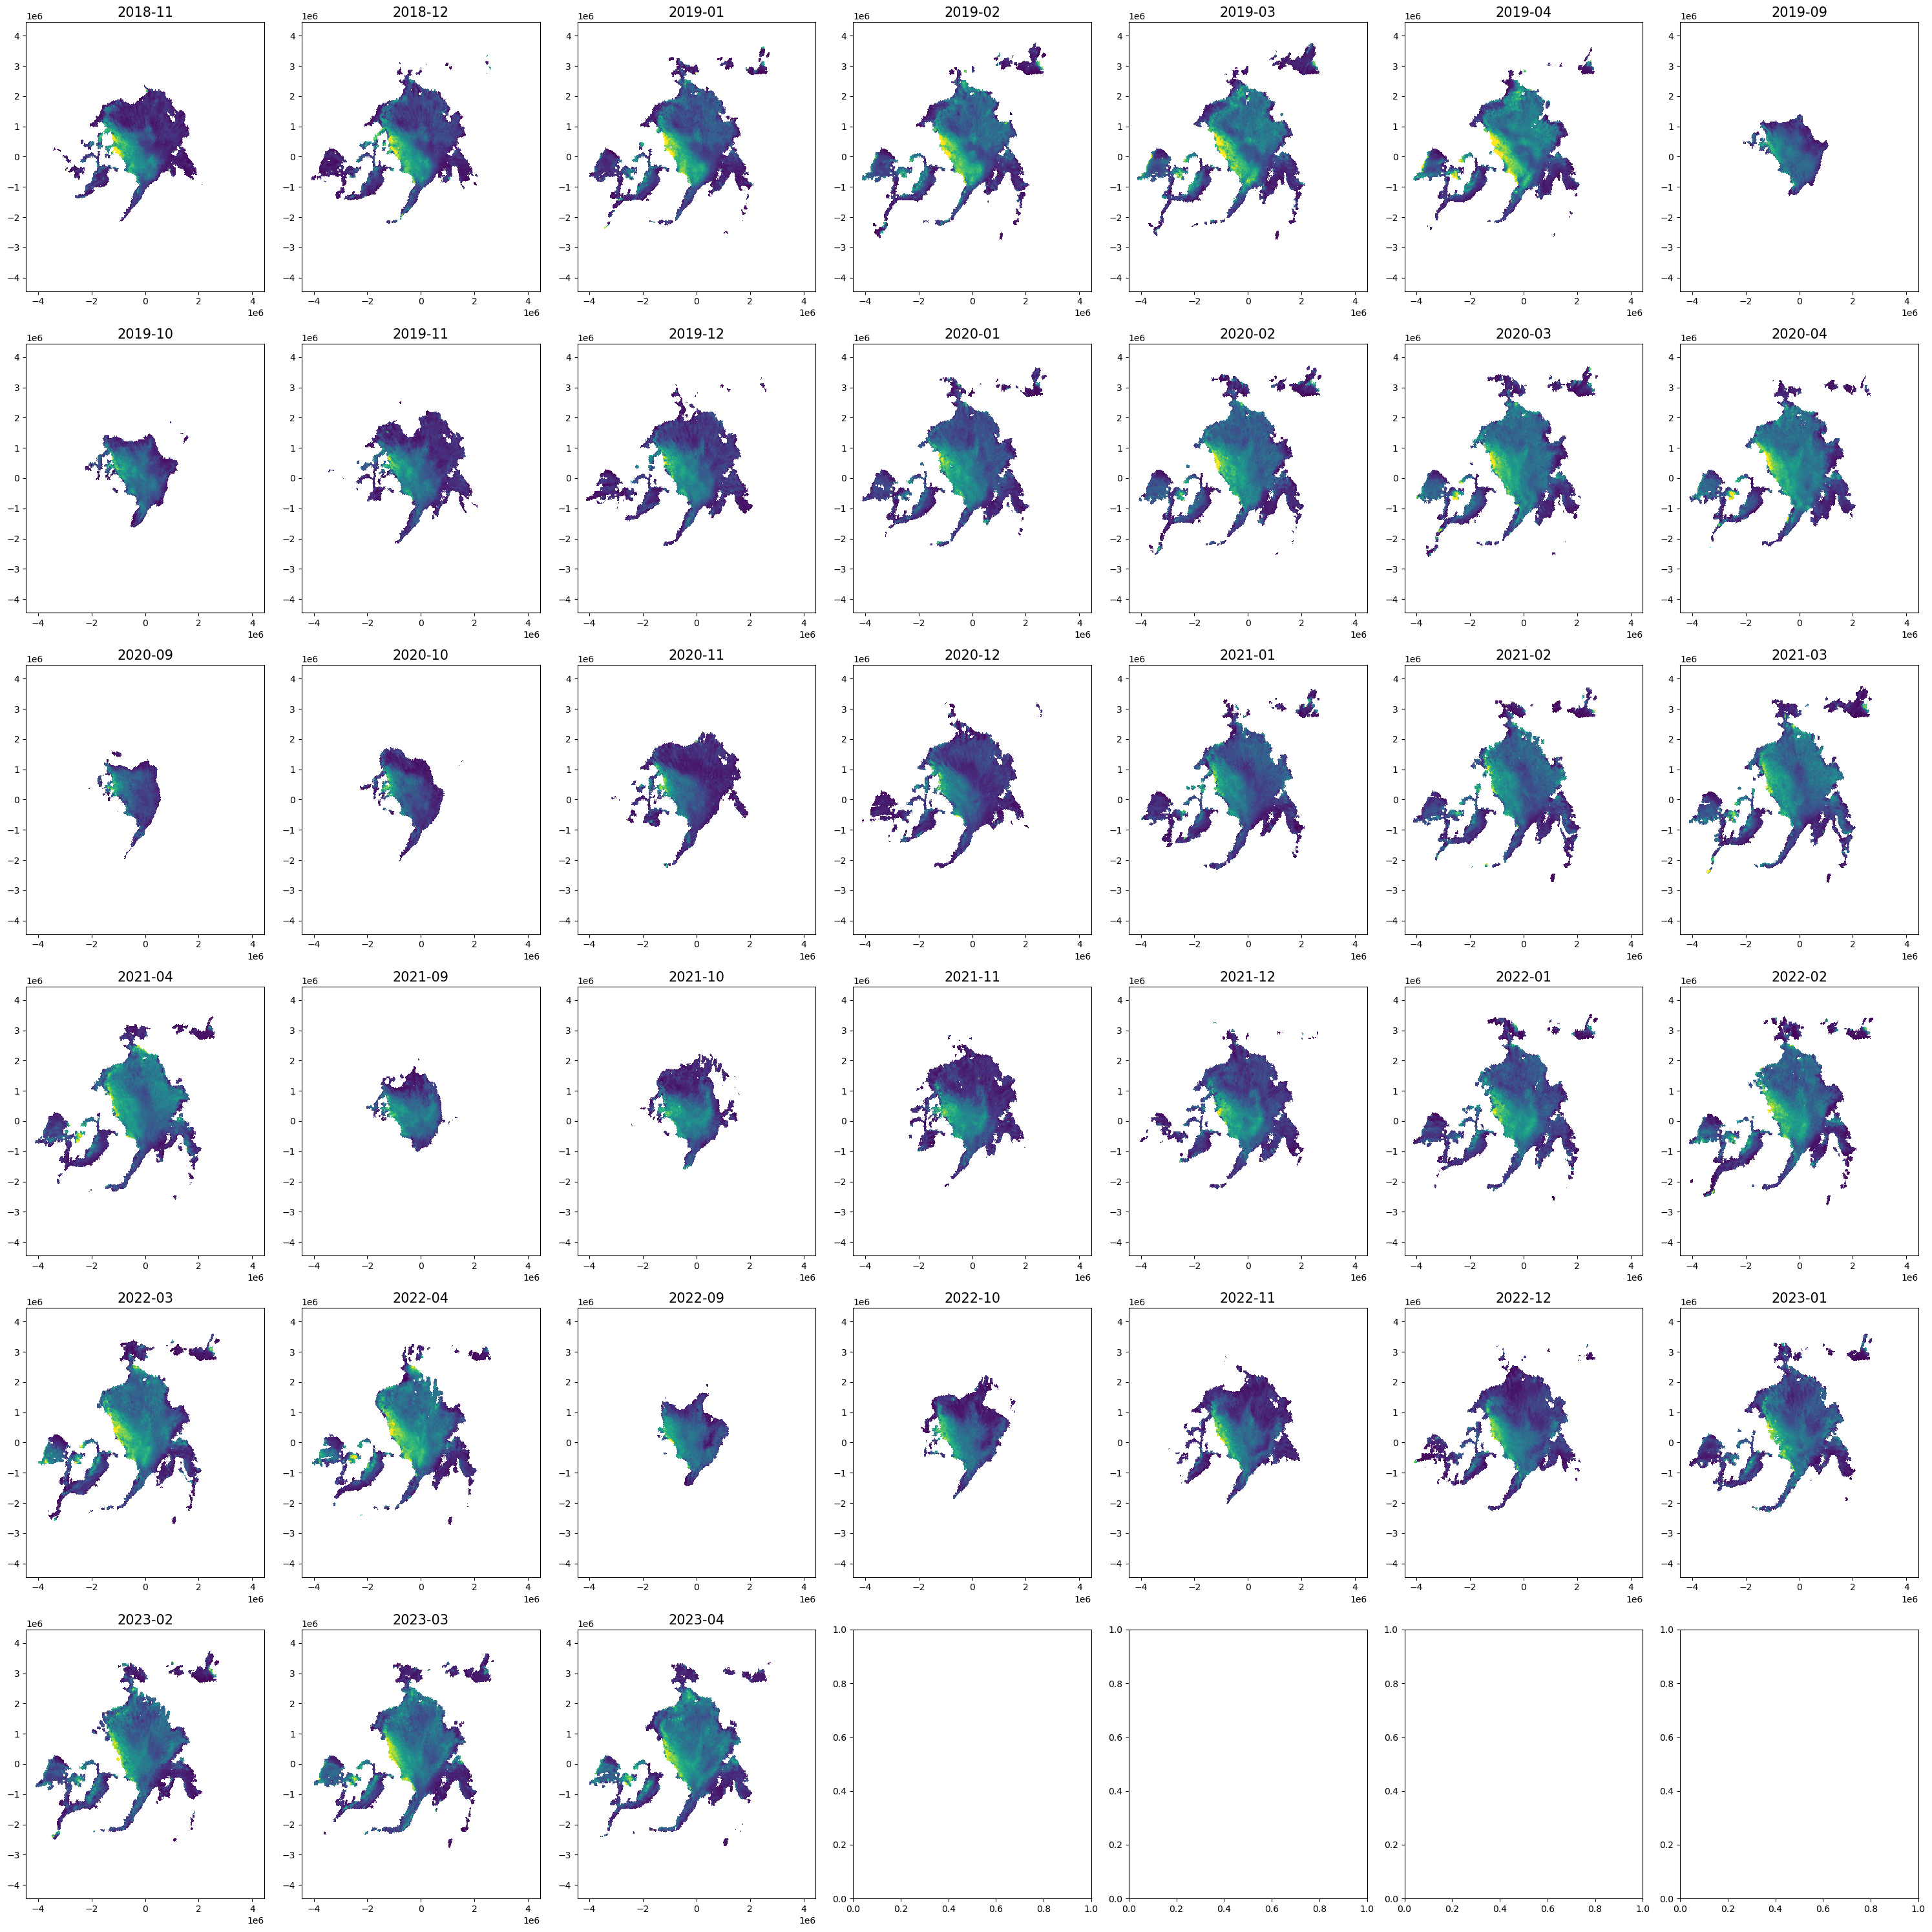

In [12]:
i=0
fig, axes = plt.subplots(6, 7, figsize=[30, 30])
for date in is2_ds_regridded.time.values:
    ax = axes.flatten()[i]
    print(str(date)[0:7])
    is2_ds_regridded_month = is2_ds_regridded.isel(time=i)
    is2_ds_regridded_month.sea_ice_thickness_int.plot(ax=ax, vmin=0, vmax=5, add_colorbar=False)
    ax.set_title(str(date)[0:7], fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
    #ax.set_xlim([-5e6, 5e6])
    #ax.set_ylim([-4e6, 4e6])
    i+=1
plt.tight_layout()

2018-11
2018-12
2019-01
2019-02
2019-03
2019-04
2019-09
2019-10
2019-11
2019-12
2020-01
2020-02
2020-03
2020-04
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-09
2021-10
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03
2023-04


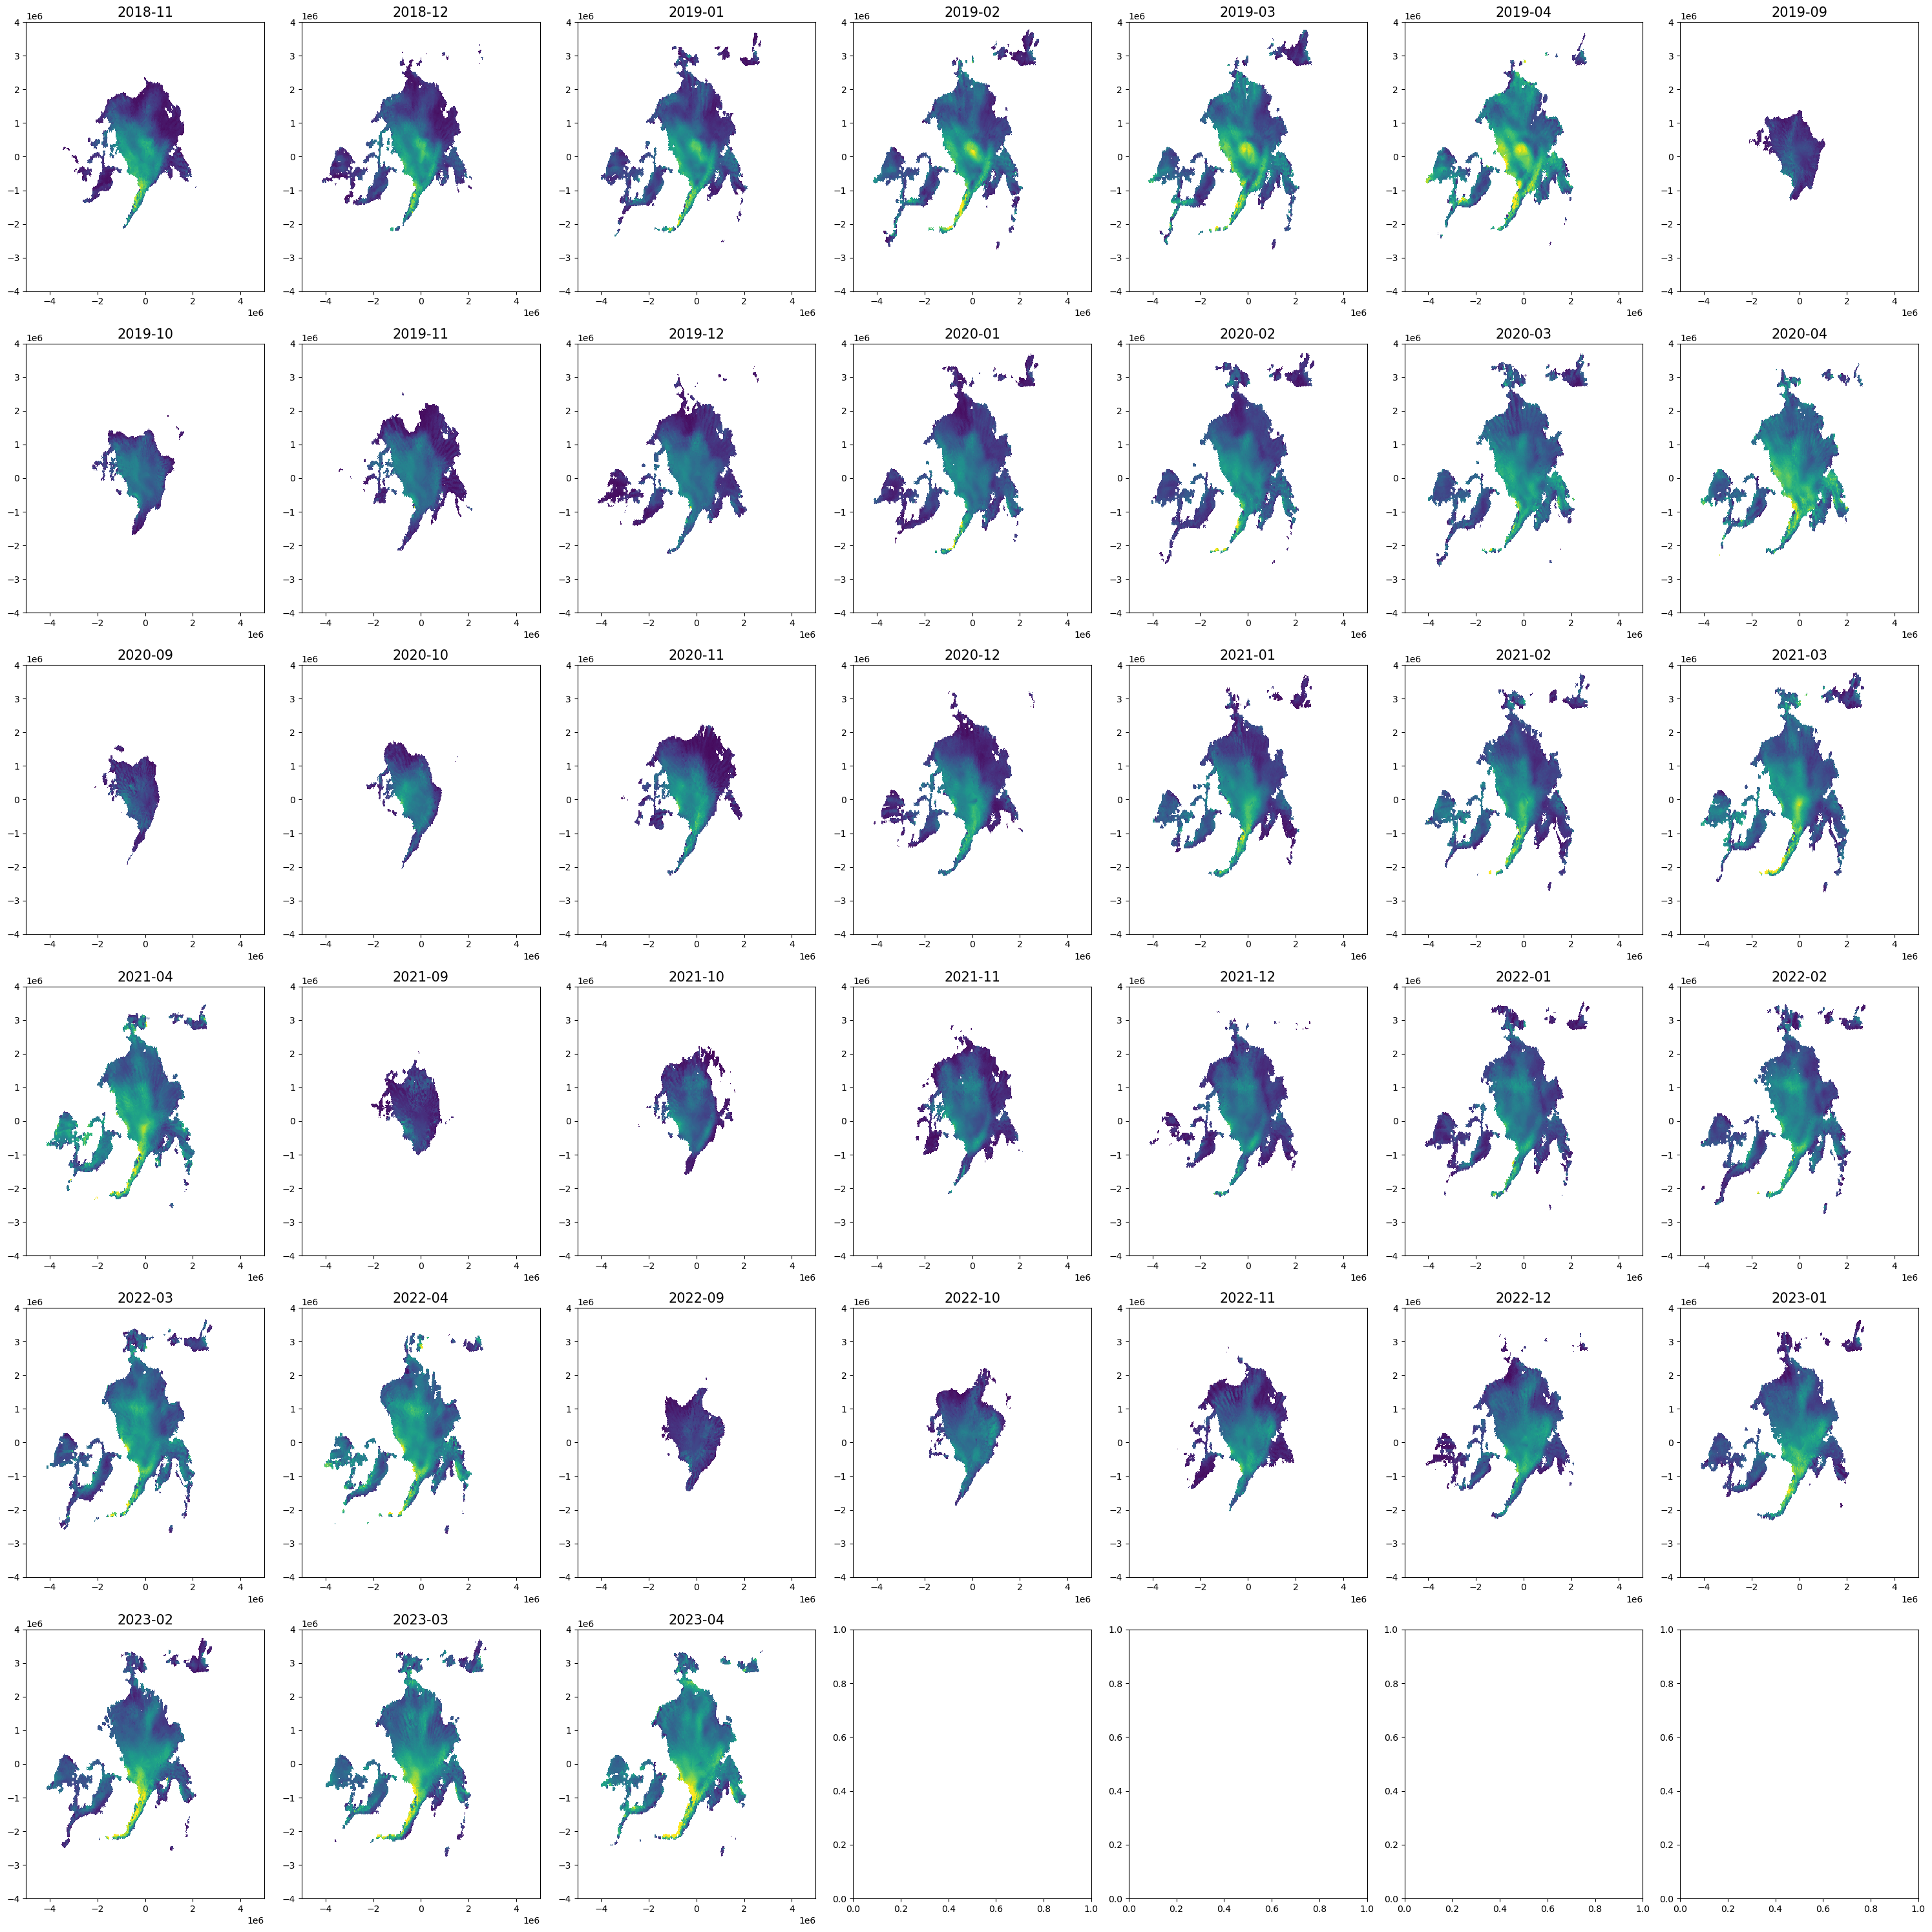

In [13]:
i=0
fig, axes = plt.subplots(6, 7, figsize=[30, 30])
for date in is2_ds_regridded.time.values:
    ax = axes.flatten()[i]
    print(str(date)[0:7])
    is2_ds_regridded_month = is2_ds_regridded.isel(time=i)
    is2_ds_regridded_month.snow_thickness_int.plot(ax=ax, vmin=0, vmax=0.5, add_colorbar=False)
    ax.set_title(str(date)[0:7], fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([-5e6, 5e6])
    ax.set_ylim([-4e6, 4e6])
    i+=1
plt.tight_layout()

2018-11
2018-12
2019-01
2019-02
2019-03
2019-04
2019-09
2019-10
2019-11
2019-12
2020-01
2020-02
2020-03
2020-04
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-09
2021-10
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03
2023-04


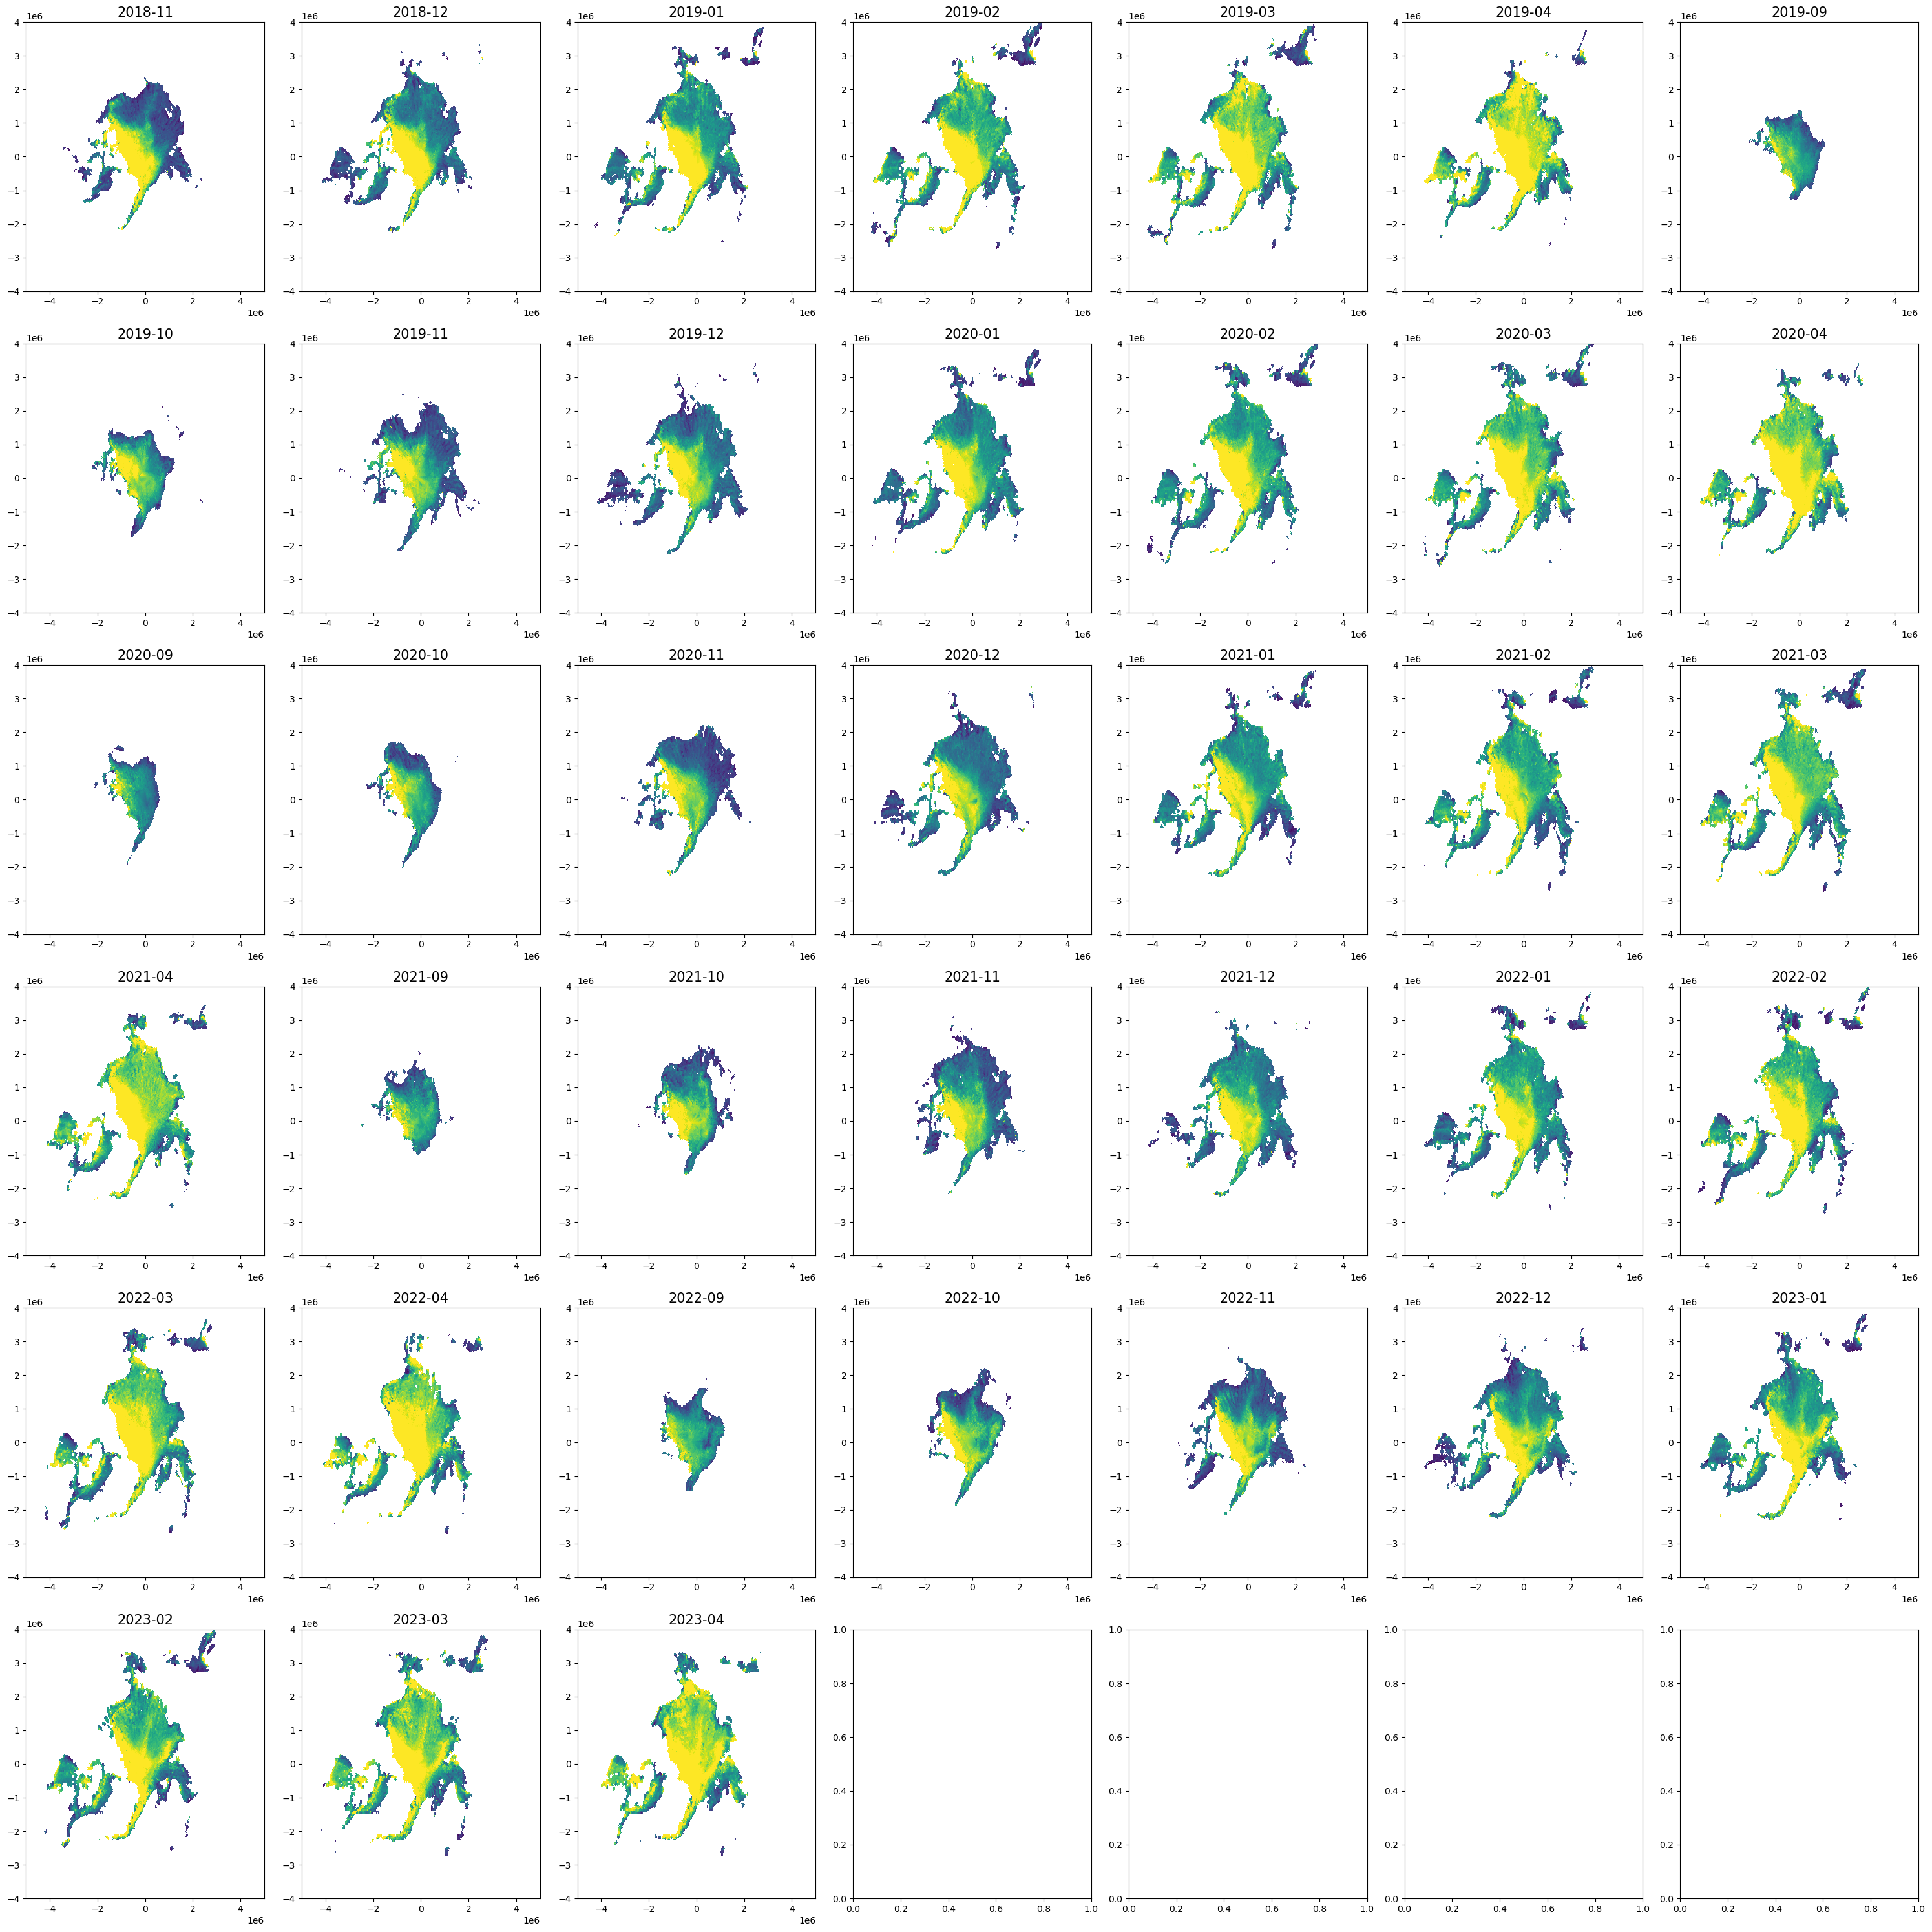

In [14]:
i=0
fig, axes = plt.subplots(6, 7, figsize=[30, 30])
for date in is2_ds_regridded.time.values:
    ax = axes.flatten()[i]
    print(str(date)[0:7])
    is2_ds_regridded_month = is2_ds_regridded.isel(time=i)
    is2_ds_regridded_month.total_freeboard_int.plot(ax=ax, vmin=0, vmax=0.4, add_colorbar=False)
    ax.set_title(str(date)[0:7], fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([-5e6, 5e6])
    ax.set_ylim([-4e6, 4e6])
    i+=1
plt.tight_layout()

In [15]:
i=0
for date in is2_ds_regridded.time.values:
    print(str(date)[0:10])
    date_s = str(pd.to_datetime(date).to_period('M').to_timestamp(how='start')).replace("-", "")[0:8]
    date_e = str(pd.to_datetime(date).to_period('M').to_timestamp(how='end')).replace("-", "")[0:8]

    is2_ds_regridded_month = is2_ds_regridded.isel(time=i)
    
    is2_ds_regridded_month_freeboard=is2_ds_regridded_month[['total_freeboard', 'total_freeboard_int']]
    is2_ds_regridded_month_snow=is2_ds_regridded_month[['snow_thickness', 'snow_thickness_int']]
    is2_ds_regridded_month_thickness=is2_ds_regridded_month[['sea_ice_thickness', 'sea_ice_thickness_int', 'sea_ice_thickness_unc']]

    is2_ds_regridded_month_thickness = is2_ds_regridded_month_thickness.assign_attrs(
        summary="Regridded (EASE2) winter Arctic sea ice thickness data from the IS2SITMOGR4 (version 3) dataset. Data regridded using nearest neighbor interpolation with the XESMF package. Note the 'int' variable indicates linear interpolated data which increases coverage. The unceratinties are calculated using theoretical propagation of uncertainties as descriebd in the NSIDC user guide. We have no associated uncertainty values for the interpolated data however. Original data can be found here: https://nsidc.org/data/is2sitmogr4/versions/3", 
        contact_email="akpetty@umd.edu",
        production_date=datetime.date.today().strftime('%Y-%m-%d'))
    
    is2_ds_regridded_month_freeboard = is2_ds_regridded_month_thickness.assign_attrs(
        summary="Regridded (EASE2) winter Arctic total freeboard data from IS2SITMOGR4 (version 3) dataset. Data regridded using nearest neighbor interpolation with the XESMF package. Note the 'int' variable indicates linear interpolated data which increases coverage. No freeboard uncertainties are included unfortunately, however we tend to assume a value of 0-4 cm based on comparisons with Operation IceBridge. Original data can be found here: https://nsidc.org/data/is2sitmogr4/versions/3, based on the release 006 ATL20 freeboard data", 
        contact_email="akpetty@umd.edu",
        production_date=datetime.date.today().strftime('%Y-%m-%d'))
    
    is2_ds_regridded_month_snow = is2_ds_regridded_month_thickness.assign_attrs(
        summary="Regridded (EASE2) winter Arctic snow thickness from redistributed NESOSIM v1.1 data included in the IS2SITMOGR4 (version 3) thickness dataset. Data regridded using nearest neighbor interpolation with the XESMF package. Note the 'int' variable indicates linear interpolated data which increases coverage. No snow thickness uncertainties are included, however we tend to assume a value of 7-10 cm based on comparisons with Operation IceBridge. Original data can be found here: https://nsidc.org/data/is2sitmogr4/versions/3", 
        contact_email="akpetty@umd.edu",
        production_date=datetime.date.today().strftime('%Y-%m-%d'))
        
    is2_ds_regridded_month_freeboard.to_netcdf(path='~/Data/IS2SITMOGR4/SINXS/SINXS_NASA_NH_SFB_SAT_IS2_'+date_s+'_'+date_e+'_V6.0.nc')
    is2_ds_regridded_month_snow.to_netcdf(path='~/Data/IS2SITMOGR4/SINXS/SINXS_NASA_NH_SNT_HYB_NESOSIMV11_'+date_s+'_'+date_e+'_V1.1.nc')
    is2_ds_regridded_month_thickness.to_netcdf(path='~/Data/IS2SITMOGR4/SINXS/SINXS_NASA_NH_SIT_SAT_IS2_'+date_s+'_'+date_e+'_V3.0.nc')
    i+=1

2018-11-01
2018-12-01
2019-01-01
2019-02-01
2019-03-01
2019-04-01
2019-09-01
2019-10-01
2019-11-01
2019-12-01
2020-01-01
2020-02-01
2020-03-01
2020-04-01
2020-09-01
2020-10-01
2020-11-01
2020-12-01
2021-01-01
2021-02-01
2021-03-01
2021-04-01
2021-09-01
2021-10-01
2021-11-01
2021-12-01
2022-01-01
2022-02-01
2022-03-01
2022-04-01
2022-09-01
2022-10-01
2022-11-01
2022-12-01
2023-01-01
2023-02-01
2023-03-01
2023-04-01
